This Project intends to predict prices of goods with information in name, item condition, shipping information, and item description. It requires processing of textual data besides usual feature engineerings in regressional problems, and texutal data is actually the most important in making predictions. Since the amount of data is large, here demonstrates preprocessing part and basic linear regression modelling without fitting complicated models. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import re
from scipy import sparse
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
%matplotlib inline

In [2]:
train = pd.read_csv('input/train.tsv', sep = '\t', index_col=['train_id'])
test = pd.read_csv('input/test.tsv', sep = '\t', index_col=['test_id'])

C:\Users\Chenxiong\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


In [4]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
# split nested category_name into 3 sub-categories
categories = train['category_name'].str.split('/', n = 2, expand=True)
train['category1'], train['category2'], train['category3'] = categories[0], categories[1], categories[2]

In [6]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category1,category2,category3
train_id,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


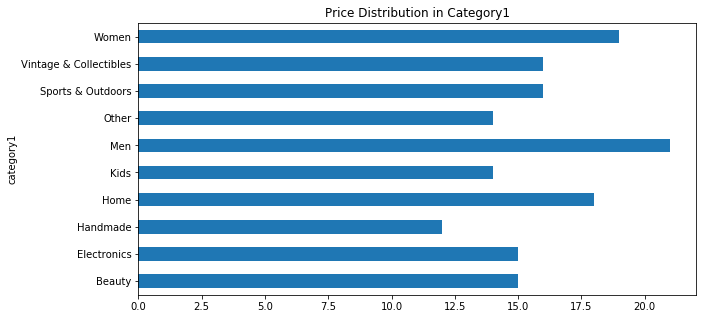

In [7]:
train.groupby('category1')['price'].median().plot(kind='barh', figsize = (10, 5), title = 'Price Distribution in Category1')

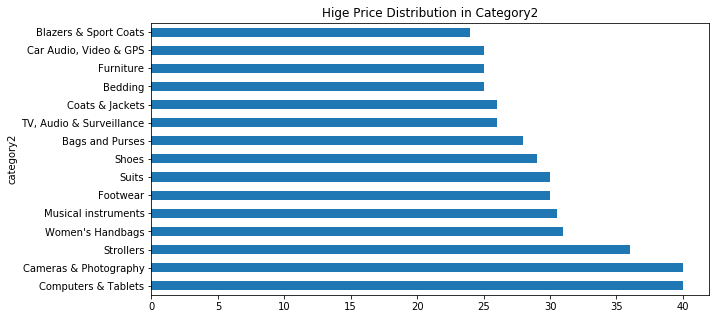

In [8]:
train.groupby('category2')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Hige Price Distribution in Category2')

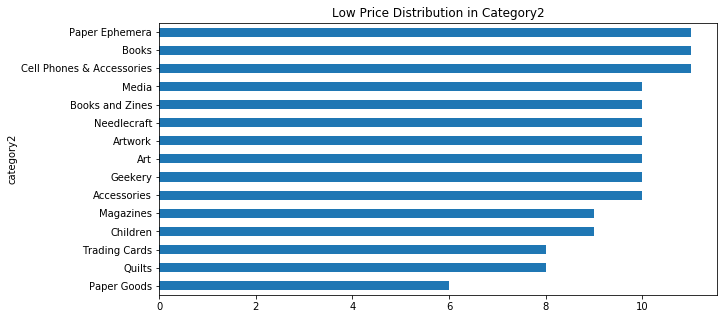

In [9]:
train.groupby('category2')['price'].median().sort_values()[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Low Price Distribution in Category2')

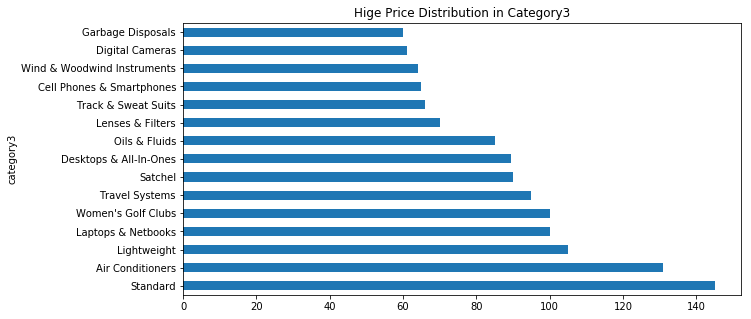

In [10]:
train.groupby('category3')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Hige Price Distribution in Category3')

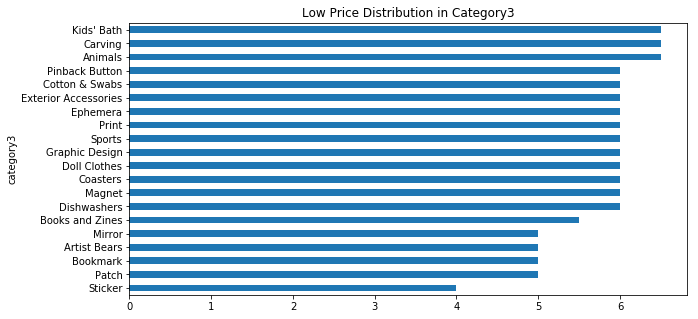

In [11]:
train.groupby('category3')['price'].median().sort_values()[:20].plot(kind='barh',  figsize = (10, 5), \
                                                                            title = 'Low Price Distribution in Category3')

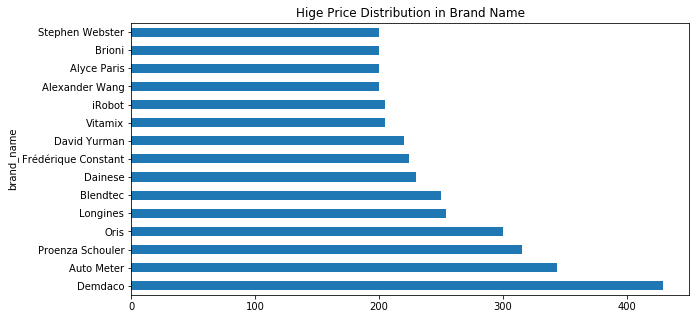

In [12]:
train.groupby('brand_name')['price'].median().sort_values(ascending=False)[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Hige Price Distribution in Brand Name')

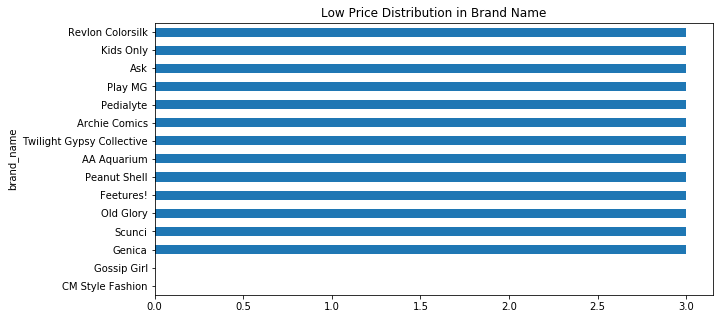

In [13]:
train.groupby('brand_name')['price'].median().sort_values()[:15].plot(kind='barh',  figsize = (10, 5), \
                                                                                    title = 'Low Price Distribution in Brand Name')

After inspection of high, low prices across sub-categories and brands, we encode top and last 1% of sub-categories and brands to make them stand out in the modelling process

In [14]:
def high_low_price(groupby):
    groupby_median = train.groupby(groupby)['price'].median()
    high_price_99 = groupby_median.quantile(.99)
    low_price_01 = groupby_median.quantile(.01)
    high_price_cat = groupby_median[groupby_median > high_price_99].index.tolist()
    low_price_cat = groupby_median[groupby_median < low_price_01].index.tolist()
    return high_price_cat, low_price_cat
cat1_high, cat1_low = high_low_price('category1')
cat2_high, cat2_low = high_low_price('category2')
cat3_high, cat3_low = high_low_price('category3')
brand_high, brand_low = high_low_price('brand_name')

In [15]:
train['cat1_high'] = np.where(train['category1'].isin(cat1_high), 1, 0)
train['cat2_high'] = np.where(train['category2'].isin(cat2_high), 1, 0)
train['cat3_high'] = np.where(train['category3'].isin(cat3_high), 1, 0)
train['cat1_low'] = np.where(train['category1'].isin(cat1_low), 1, 0)
train['cat2_low'] = np.where(train['category2'].isin(cat2_low), 1, 0)
train['cat3_low'] = np.where(train['category3'].isin(cat3_low), 1, 0)
train['brand_high'] = np.where(train['brand_name'].isin(brand_high), 1, 0)
train['brand_low'] = np.where(train['brand_name'].isin(brand_low), 1, 0)

In [16]:
pop_brand = train['brand_name'].value_counts()[:50].index.tolist()
train['pop_brand'] = np.where(train['brand_name'].isin(pop_brand), 1, 0)

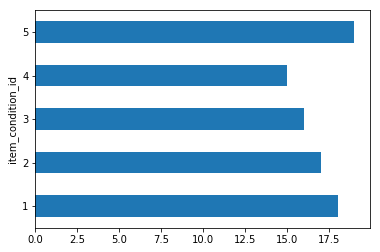

In [17]:
train.groupby('item_condition_id')['price'].median().plot(kind='barh')

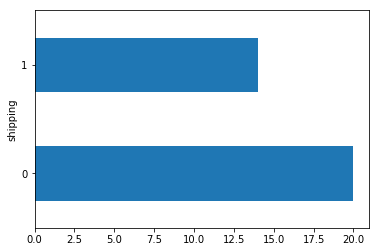

In [18]:
train.groupby('shipping')['price'].median().plot(kind='barh')

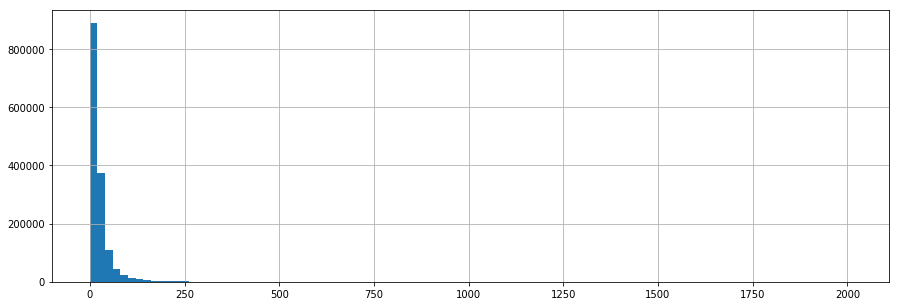

In [19]:
train['price'].hist(bins=100, figsize=(15,5))

Price is heavily skewed to the left, so let's apply log transformation

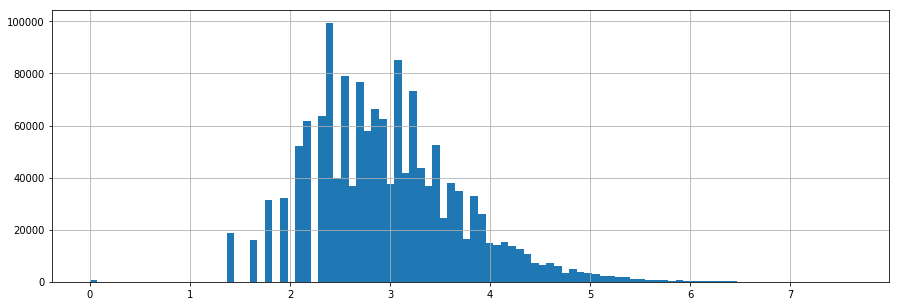

In [20]:
train['price'].apply(np.log1p).hist(bins=100, figsize=(15,5))

Log transformation gives us a much better shape of price

In [21]:
train_ = train.copy()
train_['price'] = train_['price'].apply(np.log1p)
train_.drop(['category_name'], axis=1, inplace=True)

In [22]:
train_.dropna(axis = 0, subset = ['item_description'], inplace=True)

In [23]:
train_['brand_name'].fillna('Unknown brand', inplace=True)

In [24]:
train_['category1'].fillna('Unknown category1', inplace=True)
train_['category2'].fillna('Unknown category2', inplace=True)
train_['category3'].fillna('Unknown category3', inplace=True)

In [25]:
y = train_['price']
X = train_.drop(['price'], axis=1)
strat = (y/2).apply(np.ceil)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=strat)

In [26]:
count_name = CountVectorizer(min_df = 10)
X_train_name = count_name.fit_transform(X_train['name'])
X_test_name = count_name.transform(X_test['name'])

In [27]:
# encode textual data in sub-categories with their raw frequency
count_category1, count_category2, count_category3 = CountVectorizer(), CountVectorizer(), CountVectorizer()
X_train_cat1 = count_category1.fit_transform(X_train['category1'])
X_test_cat1 = count_category1.transform(X_test['category1'])
X_train_cat2 = count_category2.fit_transform(X_train['category2'])
X_test_cat2 = count_category2.transform(X_test['category2'])
X_train_cat3 = count_category3.fit_transform(X_train['category3'])
X_test_cat3 = count_category3.transform(X_test['category3'])

In [28]:
def preprocess(text):
    """
    because sizes of lot of electronic products were not labeled uniformly (64 GB can be 64g, 64gb, 64G),
    we change different forms into one form
    """
    text = re.sub('(\d{2})\s?(gb?)', '\\1\\2', text, flags=re.IGNORECASE).upper()
    return text

In [29]:
# encode textual data with raw term frequency and inverse document frequency
count_des = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english', \
                           preprocessor = preprocess, sublinear_tf=True)
X_train_dec = count_des.fit_transform(X_train['item_description'])

In [30]:
X_test_dec = count_des.transform(X_test['item_description'])

In [31]:
# one hot encoding brand name
brand_label = LabelBinarizer(sparse_output=True)
X_train_brand = brand_label.fit_transform(X_train['brand_name'])
X_test_brand = brand_label.transform(X_test['brand_name'])

In [32]:
other_col = ['cat1_high','cat2_high', 'cat3_high', 'cat1_low', 'cat2_low', 'cat3_low',
       'brand_high', 'brand_low', 'pop_brand']
X_train_other = sparse.csr_matrix(np.c_[pd.get_dummies(X_train[['item_condition_id', 'shipping']]), 
                                        X_train[other_col]])
X_test_other = sparse.csr_matrix(np.c_[pd.get_dummies(X_test[['item_condition_id', 'shipping']]), 
                                        X_test[other_col]])


In [33]:
X_train_ = sparse.hstack((X_train_name, X_train_cat1, X_train_cat2, \
                          X_train_cat3, X_train_dec, X_train_brand, X_train_other)).tocsr()
X_test_ = sparse.hstack((X_test_name, X_test_cat1, X_test_cat2, \
                          X_test_cat3, X_test_dec, X_test_brand, X_test_other)).tocsr()

In [34]:
ridge1 = Ridge(solver='sag', random_state = 0)
ridge1.fit(X_train_, y_train)
ridge1_pred = ridge1.predict(X_train_)

In [35]:
mean_squared_log_error(np.exp(y_train), np.exp(ridge1_pred))

0.17628532075234363

In [36]:
ridge1_test = ridge1.predict(X_test_)
mean_squared_log_error(np.exp(y_test), np.exp(ridge1_test))

0.19621659615835219

Text(0.5,1,'True vs Prediction in testing for ridge1')

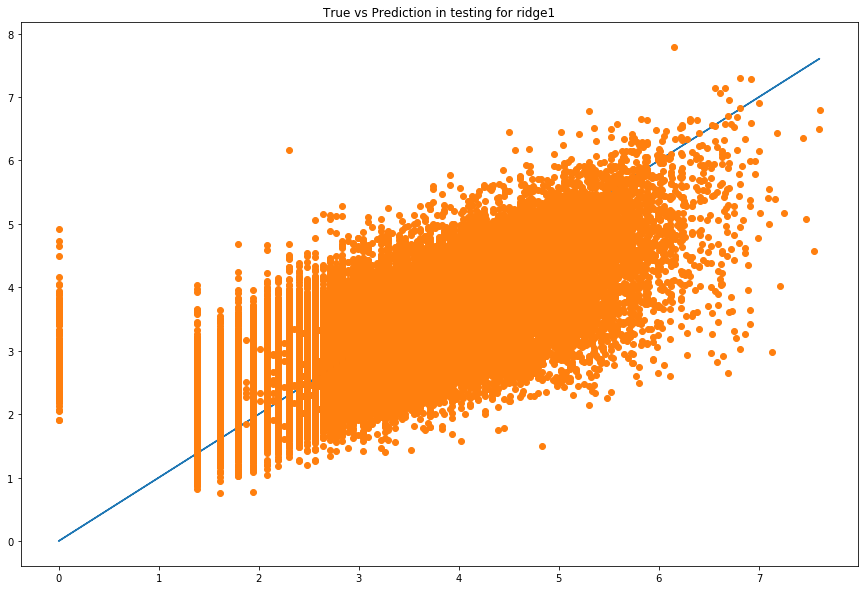

In [37]:
plt.figure(figsize=(15,10))
plt.plot(y_test, y_test, y_test, ridge1_test, 'o')
plt.title('True vs Prediction in testing for ridge1')

In [39]:
ridge2 = Ridge(alpha = 0.6, max_iter = 100, random_state = 0, solver = 'auto', tol = 0.01)
ridge2.fit(X_train_, y_train)
ridge2_pred = ridge2.predict(X_train_)

In [40]:
mean_squared_log_error(np.exp(y_train), np.exp(ridge2_pred))

0.1769661968155395

In [41]:
ridge2_test = ridge2.predict(X_test_)
mean_squared_log_error(np.exp(y_test), np.exp(ridge2_test))

0.19623972888813182

Text(0.5,1,'True vs Prediction in testing for ridge2')

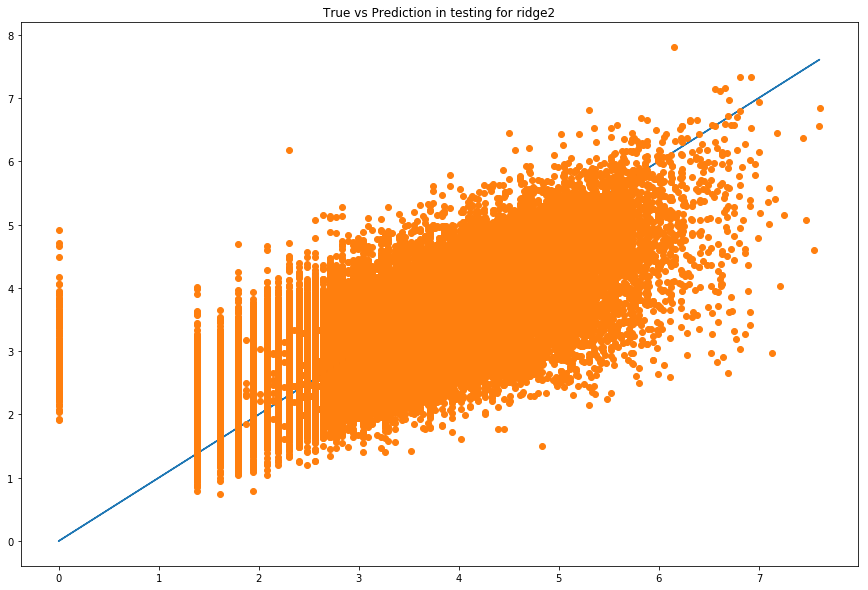

In [42]:
plt.figure(figsize=(15,10))
plt.plot(y_test, y_test, y_test, ridge2_test, 'o')
plt.title('True vs Prediction in testing for ridge2')

Though two ridge models have similar plots, let's average them to see whether accuracy will be better

In [46]:
mean_squared_log_error(np.exp(y_test), np.exp(ridge1_test)*0.5 + np.exp(ridge2_test)*0.5)

0.19619564299208034

The combined prediction leads us to a slightly better result!